In [1]:
# Imports
import matplotlib
import scipy.io
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
from sklearn.linear_model import LinearRegression
import matplotlib.transforms as mtransforms


# Known data
G = 0.14 # Nms
I = 0.15 # kgm^2
tau = 60 # ms
# geometry
l_forearm = 33 # cm - wrist-elbow
l_arm = 30 # cm - elbow-shoulder
# targets
r = 18 # cm
t = 0.6 # s - time reaching movement


In [2]:
# functions

def cost_matrix(weights, shape):
    Q = np.zeros((shape, shape))
    
    for i in range(shape):
        for j in range(shape):
            if i < shape // 2 and j < shape // 2:
                Q[i, j] = weights[i] if i == j else 0
            elif i >= shape // 2 and j >= shape // 2:
                Q[i, j] = weights[i - shape // 2] if i - shape // 2 == j - shape // 2 else 0
            elif i < shape // 2 and j >= shape // 2:
                Q[i, j] = -weights[j - shape // 2] if i == j - shape // 2 else 0
            elif i >= shape // 2 and j < shape // 2:
                Q[i, j] = -weights[i - shape // 2] if i - shape // 2 == j else 0
    
    return Q



In [3]:
def backwards_optimal_control(N, A, B, Q, Qk, R, shape):
    # amount of matrices = amount of time steps
    S = np.zeros((N,shape,shape))
    S[N-1,:,:] = Q
    L = np.zeros((N,B.shape[1],shape))  # Changed L to a 2D array
    R_matrix = R*np.eye(B.shape[1])
    #print('R_matrix ', R_matrix)
    
    # backward pass
    for k in range(N-1,0, -1):
        # print("K = ", k)
        temp_1 = np.linalg.inv(R_matrix + (B.T @ S[k,:,:] @ B))
        temp_2 = B.T @ S[k,:,:] @ A
        L[k - 1,:,:] = temp_1 @ temp_2
        S[k - 1,:,:] = Qk + (A.T @ S[k,:,:] @ A) - (A.T @ S[k,:,:] @ B) @ L[k - 1,:,:]

    return L, S

In [4]:
def forward_optimal_control(N, A, B, R, L, x, shape):
    w = np.random.normal(0, 0.000001, (shape,1))
    for i in range(0, N - 1):
        x[i + 1,:,:] = (A - B @ L[i,:,:]) @ x[i,:,:] + w
    return x

In [5]:
def feedback(A, B, shape, N, x_hat, x):
    means = np.zeros(shape)
    cov_ksi = np.zeros((shape,shape))
    for i in range(0,shape) :
        cov_ksi[i,i] = np.abs(np.random.normal(0, 0.001))

    cov_w = np.zeros((shape,shape))
    for i in range(0,shape) :
        cov_w[i,i] = np.abs(np.random.normal(0, 0.001))
    
    H = np.eye(shape)
    sigma = np.zeros((N,shape,shape))
    sigma[0,:,:] = cov_w
    y = np.zeros((N,shape,1))
    K = np.zeros((N,shape,shape))
    u = np.ones((B.shape[1],1))
    for k in range(0,N-1) :
        w = np.random.multivariate_normal(means, cov_w).reshape((shape,1))
        K[k,:,:] = A @ sigma[k,:,:] @ H.T @ np.linalg.inv(H @ sigma[k,:,:] @ H.T + cov_w)
        sigma[k+1,:,:] = cov_ksi + (A - K[k,:,:] @ H) @ sigma[k,:,:] @ A.T
        y[k,:,:] = H @ x[k,:,:] + w
        x_hat[k+1,:,:] = A @ x_hat[k,:,:] + B @ u + K[k,:,:] @ (y[k,:,:] - H @ x_hat[k,:,:])
    
    return x_hat

C:  [27.87867965644036, 44.5477272147525]
targets  [(18.0, 0.0), (12.727922061357857, 12.727922061357857), (1.102182119232618e-15, 18.0), (-12.727922061357855, 12.727922061357857), (-18.0, 2.204364238465236e-15), (-12.727922061357859, -12.727922061357855), (-3.3065463576978533e-15, -18.0), (12.727922061357852, -12.727922061357859)]


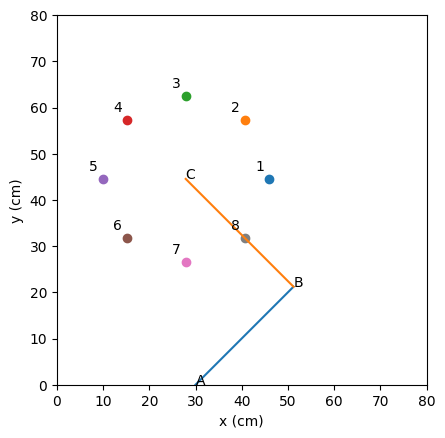

In [6]:
# plot starting position
theta_shoulder = 0
theta_elbow = 0
A = [30,0]
theta_shoulder = np.pi/4 # rad
theta_elbow = np.pi*3/4 #  rad
# compute joint positions 
B = [0,0]
B[0] = A[0] + np.cos(theta_shoulder)*l_arm
B[1] = A[1] + np.sin(theta_shoulder)*l_arm
C = [0,0]
C[0] = B[0] + np.cos(theta_elbow)*l_forearm
C[1] = B[1] + np.sin(theta_elbow)*l_forearm
print('C: ', C)
#print('theta_shoulder (rad) ', theta_shoulder)
#print('theta_shoulder (deg) ', np.rad2deg(theta_shoulder))

# targets
points = [(np.cos(2*np.pi/8*x)*18,np.sin(2*np.pi/8*x)*18) for x in range(0,8)]
print('targets ', points)

# figure 
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
centre = (C[0],C[1])
#ax.add_patch(Circle(centre,18,fill=False))
labels = ['1','2','3','4','5','6','7','8']
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=0.05, units='inches')
for i in range(0,8):
    plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
    plt.text(C[0]+points[i][0],C[1]+points[i][1],labels[i],transform=trans_offset,ha='right',va='bottom')
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.plot([A[0],B[0]],[A[1],B[1]])
plt.plot([B[0],C[0]],[B[1],C[1]])
labels = ['A','B','C']
plt.text(A[0],A[1],'A')
plt.text(B[0],B[1],'B')
plt.text(C[0],C[1],'C')

plt.show()

theta_elbow:  1.6961915899782931
theta_shoulder:  0.46372505314601187


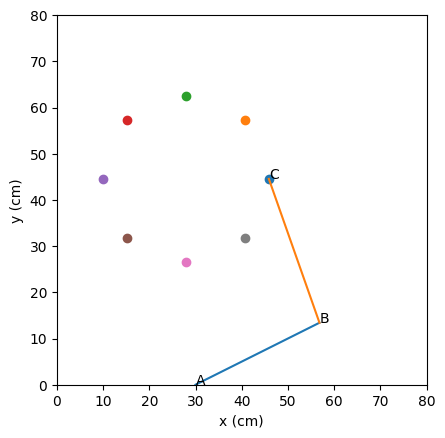

theta_elbow:  2.3590044223386495
theta_shoulder:  0.9767478019494162


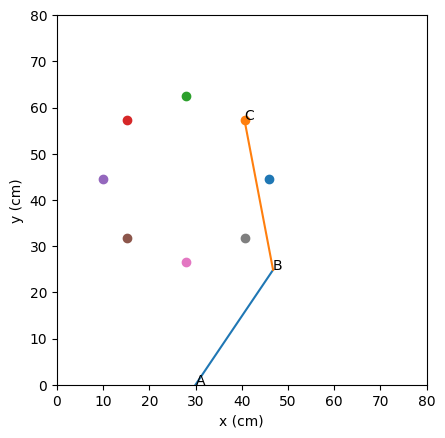

theta_elbow:  2.9112798722714213
theta_shoulder:  1.4840342174350751


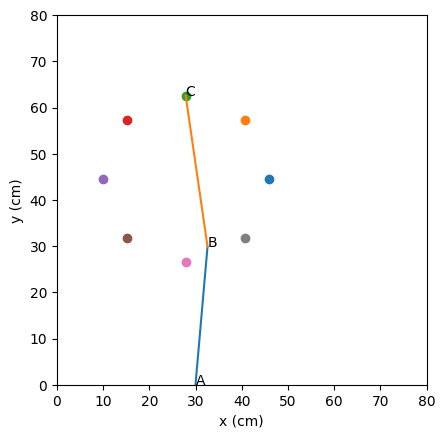

theta_elbow:  2.4397229633766044
theta_shoulder:  1.456104568879614


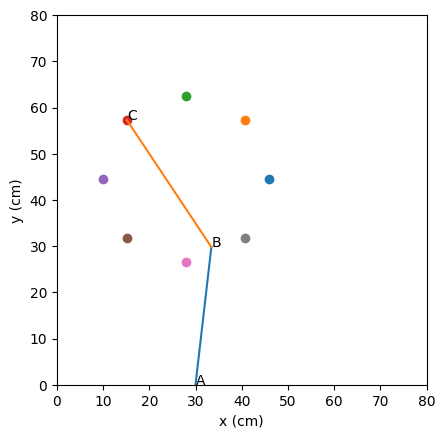

theta_elbow:  1.7744060771477956
theta_shoulder:  1.2726811565121343


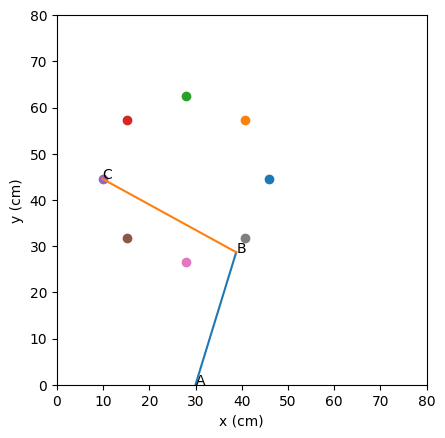

theta_elbow:  1.1790336040916527
theta_shoulder:  0.9550691234573447


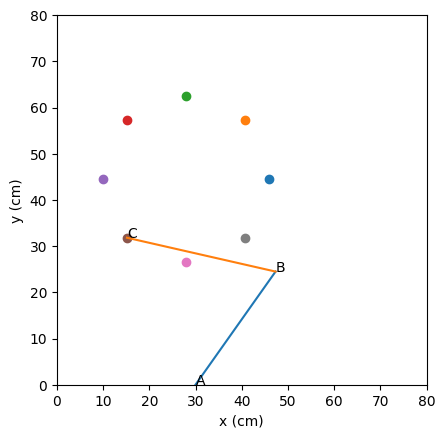

theta_elbow:  0.8680414145856283
theta_shoulder:  0.41137765098985657


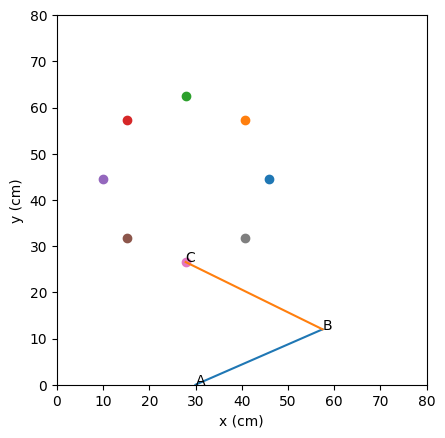

theta_elbow:  1.119243067849574
theta_shoulder:  0.16199943147742935


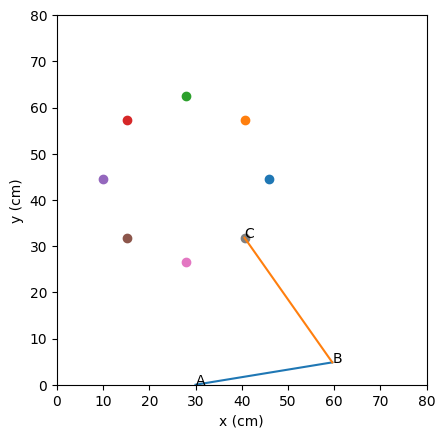

theta_1:  [0.78539816 0.46372505 0.9767478  1.48403422 1.45610457 1.27268116
 0.95506912 0.41137765 0.16199943]
theta_2:  [1.57079633 1.69619159 2.35900442 2.91127987 2.43972296 1.77440608
 1.1790336  0.86804141 1.11924307]


In [7]:
### 2 joints ################
# constants
A = [30,0]

# initial position
theta_shoulder_0 = np.pi/4 # 45 deg
theta_elbow_0 = np.pi/2 # 90 deg

# figure
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

angles = np.zeros((2,9))
# save initial position
angles[0,0] = theta_shoulder_0 
angles[1,0] = theta_elbow_0

count_targets_reached = 0
for point in points :
    target = [C[0]+point[0], C[1]+point[1]]
    #print('target: ',target)
    # distance A-target
    A_target = np.sqrt((target[0]-A[0])**2+(target[1]-A[1])**2)
    #print('AC: ',A_target)
    
    # angle between AC and x-axis
    beta = np.arccos((A[0]-target[0])/A_target)
    # angle between AC and AB
    alpha = np.arccos((A_target**2+l_arm**2-l_forearm**2)/(2*A_target*l_arm))
    
    theta_elbow = np.arccos((l_arm**2+l_forearm**2-A_target**2)/(2*l_arm*l_forearm)) # theta_2 (rad)
    print('theta_elbow: ', theta_elbow)
    theta_shoulder = np.pi-beta-alpha # theta_1 (rad)
    print('theta_shoulder: ', theta_shoulder)
    
    count_targets_reached += 1
    # save the angles corresponding to the position of the arm once it reached the target
    angles[0,count_targets_reached] = theta_shoulder
    angles[1,count_targets_reached] = theta_elbow
    
    
    # compute joint positions
    A = [30,0]
    B = [0,0]
    B[0] = A[0] + np.cos(theta_shoulder)*l_arm
    B[1] = A[1] + np.sin(theta_shoulder)*l_arm
    BC = np.sqrt((target[0]-B[0])**2+(target[1]-B[1])**2)
    #print('BC: ',BC)
    
    # figure 
    plt.cla()
    plt.gca().set_aspect('equal', adjustable='box')
    centre = (C[0],C[1])
    #ax.add_patch(Circle(centre,18,fill=False))
    for i in range(0,8):
        plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.xlabel("x (cm)")
    plt.ylabel("y (cm)")
    plt.plot([A[0],B[0]],[A[1],B[1]])
    plt.plot([B[0],target[0]],[B[1],target[1]])
    labels = ['A','B','C']
    plt.text(A[0],A[1],'A')
    plt.text(B[0],B[1],'B')
    plt.text(target[0],target[1],'C')
    
    plt.show()

print("theta_1: ", angles[0,:])
print("theta_2: ", angles[1,:])

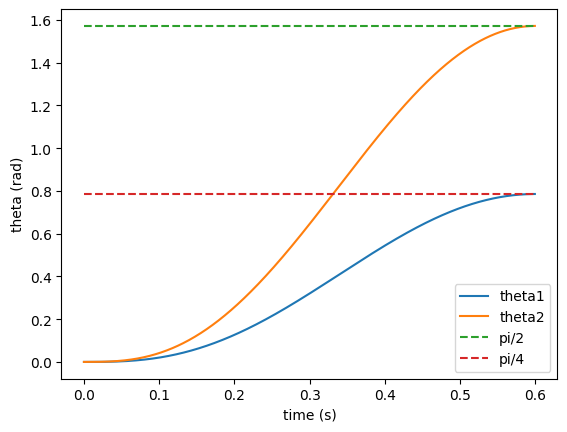

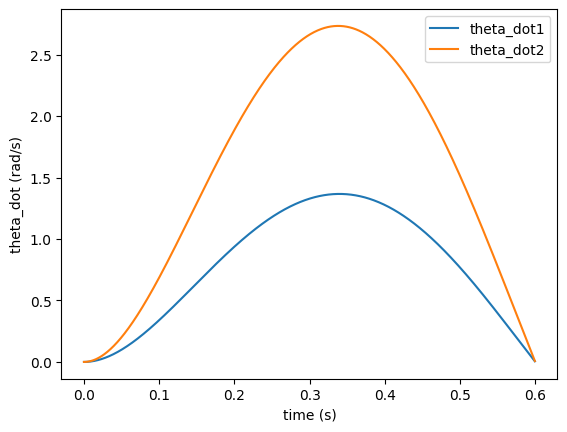

In [8]:
# One Joint Recursion Coding
theta = 0 #np.pi/4
theta_dot = 0
T = 0
dt = 0.001

Qk = np.zeros((6,6))
R = 0.0001
# weight matrix for one joint
weights = [100, 10, 0]
Q = cost_matrix(weights, 6)  

A = np.array([1,dt,0,0,0,0,0,1 - (dt * G/I),1 + dt/I,0,0,0,0,0,1 - dt/tau,0,0,0,
              0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1]).reshape((6,6))
B = np.array([0,0,(dt/tau),0,0,0]).reshape(6,1)

N = 1000

(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 6)

x = np.zeros((N,6,1))
x[0,:,:] = np.array([theta,theta_dot, T, np.pi/4, 0, 0]).reshape((6,1))
x = forward_optimal_control(N, A, B, R, L, x, 6) 

x2 = np.zeros((N,6,1))
x2[0,:,:] = np.array([theta,theta_dot, T, np.pi/2, 0, 0]).reshape((6,1))
x2 = forward_optimal_control(N, A, B, R, L, x2, 6) 

# Plot the results
fig, ax = plt.subplots()
time = 0.6 # seconds
x_axis = np.arange(0, time, time/N)
plt.plot(x_axis, x[:,0,0], label = "theta1")
plt.plot(x_axis, x2[:,0,0], label = "theta2")
# axis labels
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
# plot a dotted line on for y = pi/2 and y = pi/4
plt.plot(x_axis, np.ones(N)*np.pi/2, '--', label = "pi/2")
plt.plot(x_axis, np.ones(N)*np.pi/4, '--', label = "pi/4")
# draw a small dot in the beginning of each dotted line with the proper caption of y = pi/2 and y = pi/4
plt.legend()
fig, ax = plt.subplots()
plt.plot(x_axis, x[:,1,0], label = "theta_dot1")
plt.plot(x_axis, x2[:,1,0], label = "theta_dot2")
plt.xlabel('time (s)')
plt.ylabel('theta_dot (rad/s)')

plt.legend()
plt.show()


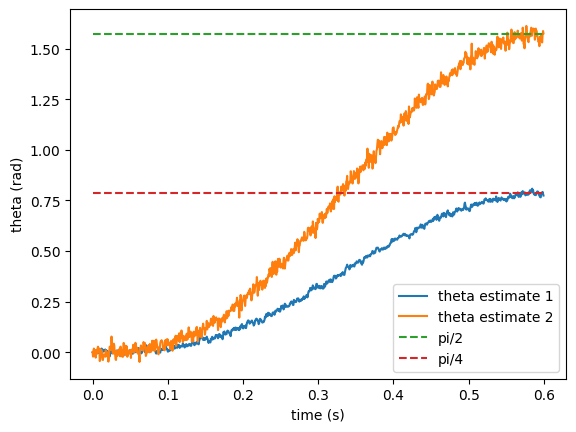

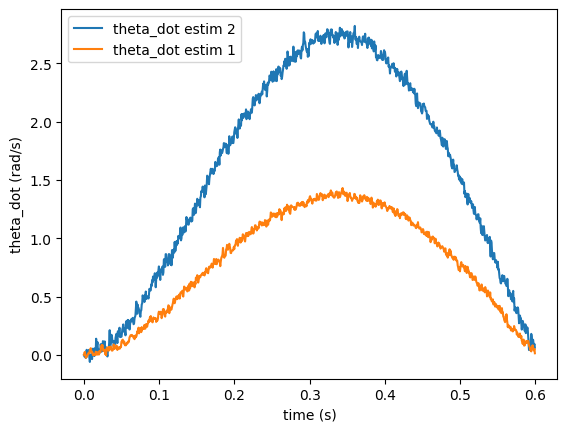

In [9]:
# Add feedback to the 1 joint model

### definition of the state
# x[k+1] = A*x[k] + B*u[k] + ksi[k]
# y[k] = H*x[k] + w[k]

dt = 0.001
N = 1000
# matrices
A = np.array([1,dt,0,0,0,0,
              0,1-((dt*G)/I),1+dt/I,0,0,0,
              0,0,(1-dt/tau),0,0,0,
              0,0,0,1,0,0,
              0,0,0,0,1,0,
              0,0,0,0,0,1]).reshape((6,6))
#print("A matrix : ","\n",A)
B = np.array([0,0,(dt/tau),0,0,0]).reshape(6,1)
#print("B vector : ","\n",B)

### state estimation
# x_hat[k+1] = A*x_hat[k] + B*u[k] + K[k]*(y[k] - H*x_hat[k])

# find x_hat, the estimation of x
x_hat = np.zeros((N,6,1))
# initialization
theta = 0
theta_dot = 0
T = 0
x_hat[0,:,:] = np.array([theta,theta_dot,T,np.pi/4,0,0]).reshape((6,1)) 

x_hat = feedback(A, B, 6, N, x_hat, x)

x_hat2 = np.zeros((N,6,1))
x_hat2[0,:,:] = np.array([theta,theta_dot,T,np.pi/2,0,0]).reshape((6,1)) 
x_hat2 = feedback(A, B, 6, N, x_hat2, x2)
    
# Plot the results
x_axis = np.arange(0, 0.6, 0.6/N)

fig, ax = plt.subplots()
plt.plot(x_axis, x_hat[:,0,0], label = "theta estimate 1")
plt.plot(x_axis, x_hat2[:,0,0], label = "theta estimate 2")
# axis labels
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
# plot a dotted line on for y = pi/2 and y = pi/4
plt.plot(x_axis, np.ones(1000)*np.pi/2, '--', label = "pi/2")
plt.plot(x_axis, np.ones(1000)*np.pi/4, '--', label = "pi/4")

plt.legend()
fig, ax = plt.subplots()
plt.plot(x_axis, x_hat2[:,1,0], label = "theta_dot estim 2")
plt.plot(x_axis, x_hat[:,1,0], label = "theta_dot estim 1")
plt.xlabel('time (s)')
plt.ylabel('theta_dot (rad/s)')

plt.legend()
plt.show()


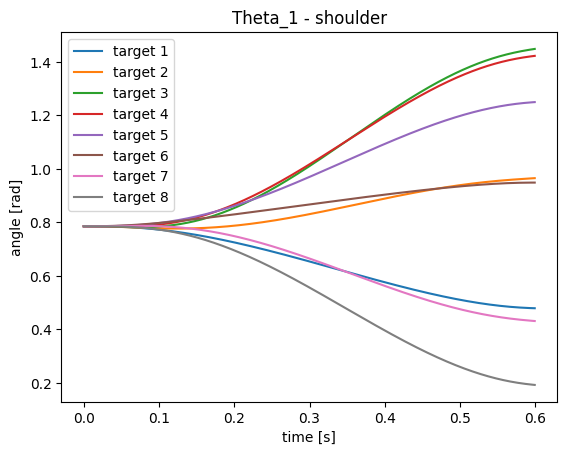

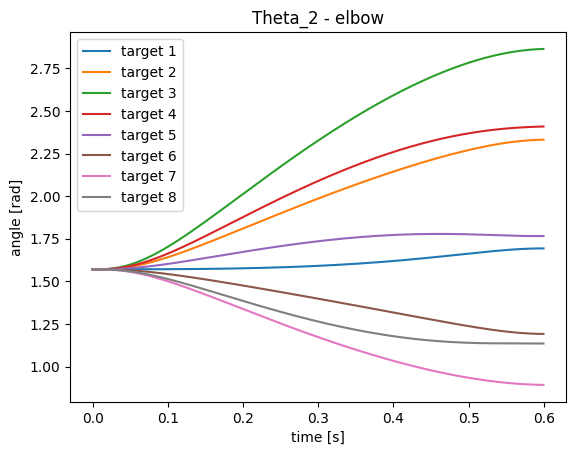

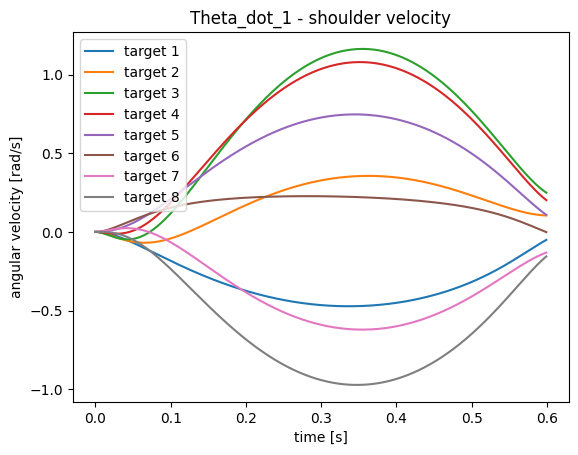

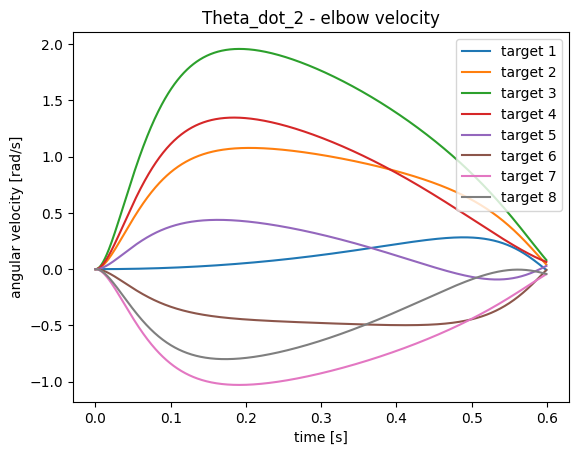

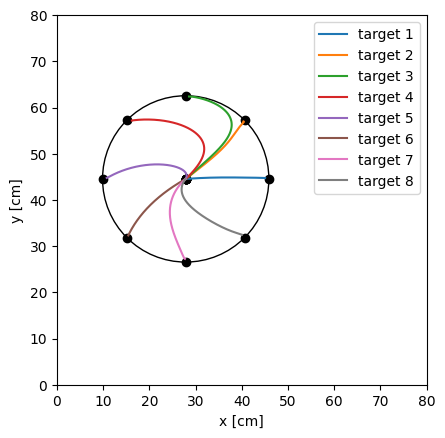

In [10]:
theta_1 = np.pi/4
theta_2 = np.pi/2
theta_dot_1 = 0
theta_dot_2 = 0
T_1 = 0
T_2 = 0

A_primary = matrix = np.array([
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 0, 0,
    0, 0, -0.093353, -3.547423, 7.46826, -7.46826,
    0, 0, -2.991867, 14.658535, -7.46826, 29.6904,
    0, 0, 0, 0, -16.6667, 0,
    0, 0, 0, 0, 0, -16.6667
]).reshape(6, 6)

B_primary = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1/tau, 0, 0, 1/tau]).reshape(6, 2)

# A = [A*dt + eye(6) , 0 ; 0 , eye(6)]
A = np.concatenate((A_primary * dt + np.eye(6), np.zeros((6, 6))), axis=1)
A = np.concatenate((A, np.concatenate((np.zeros((6, 6)), np.eye(6)), axis=1)), axis=0)
B = np.concatenate((B_primary * dt, np.zeros((6,2))), axis=0)
#print("A matrix : ","\n",A)
#print("B vector : ","\n",B)
# print("A shape : ", A.shape)
# print("B shape : ", B.shape)

weights = np.array([10**6,10**6,10**5,10**5,1,1])
Q = cost_matrix(weights, 12)

Qk = np.zeros((12,12))
R = 0.0001 
N = 1000
(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 12)

# plot L_11
#fig, (ax1, ax2) = plt.subplots(1, 2)
#plt.plot(L[:,0,0], label='L11')
#plt.plot(L[:,0,2], label='L12')
#plt.legend()

## plot
time = 0.6 # seconds
A_point = [30,0]
C_point = np.zeros((8,2,N))

## for every target
# angles
for i in range(1,9) :
    x = np.zeros((N,12,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A, B, R, L, x, 12)
    theta_shoulder = x[:,0,0] # rad
    theta_elbow = x[:,1,0]    # rad
    plt_theta_elbow = np.pi - theta_elbow + theta_shoulder
    # compute joint positions 
    B_point = [0,0]
    B_point[0] = A_point[0] + np.cos(theta_shoulder)*l_arm
    B_point[1] = A_point[1] + np.sin(theta_shoulder)*l_arm
    C_point[i-1,0,:] = B_point[0] + np.cos(plt_theta_elbow)*l_forearm
    C_point[i-1,1,:] = B_point[1] + np.sin(plt_theta_elbow)*l_forearm
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,0,0], label = 'target '+str(i))
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_1 - shoulder')
    plt.legend()
plt.show()
for i in range(1,9) :
    x = np.zeros((N,12,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A, B, R, L, x, 12)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,1,0], label = 'target '+str(i))
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_2 - elbow')
    plt.legend()
plt.show()
# velocities
for i in range(1,9) :
    x = np.zeros((N,12,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A, B, R, L, x, 12)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,2,0], label = 'target '+str(i))
    plt.xlabel("time [s]")
    plt.ylabel("angular velocity [rad/s]")
    plt.title('Theta_dot_1 - shoulder velocity')
    plt.legend()
plt.show()
for i in range(1,9) :
    x = np.zeros((N,12,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A, B, R, L, x, 12)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,3,0], label = 'target '+str(i))
    plt.xlabel("time [s]")
    plt.ylabel("angular velocity [rad/s]")
    plt.title('Theta_dot_2 - elbow velocity')
    plt.legend()
plt.show()

## plot on the x-y plane
# targets
points = [(np.cos(2*np.pi/8*x)*18,np.sin(2*np.pi/8*x)*18) for x in range(0,8)]
# figure 
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
for i in range(0,8):
    plt.scatter(centre[0]+points[i][0],centre[1]+points[i][1],color = 'k')
    plt.scatter(centre[0], centre[1], color = 'k')
    plt.plot(C_point[i,0,:],C_point[i,1,:],label = 'target '+str(i+1))
ax.add_patch(Circle(centre,18,fill=False))
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.legend()
plt.show()

#print(C_point[7,:,:])

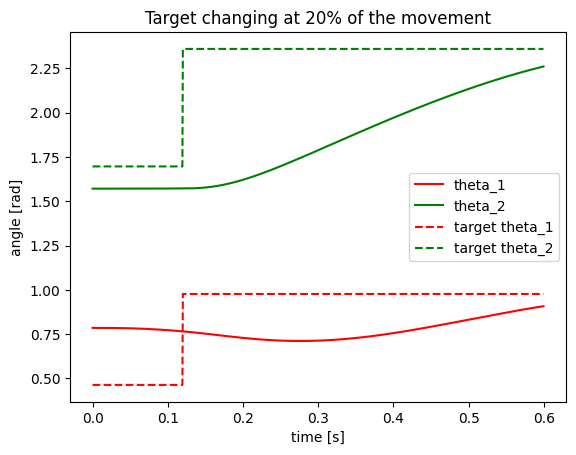

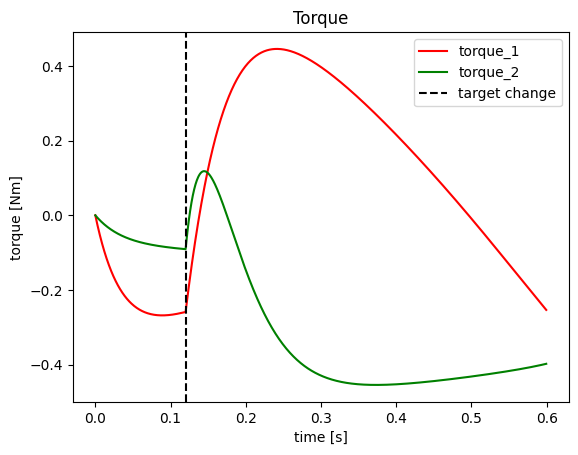

In [11]:
### Implement visual perturbations ###

theta_1 = np.pi/4
theta_2 = np.pi/2
theta_dot_1 = 0
theta_dot_2 = 0
T_1 = 0
T_2 = 0

A_primary = matrix = np.array([
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 0, 0,
    0, 0, -0.093353, -3.547423, 7.46826, -7.46826,
    0, 0, -2.991867, 14.658535, -7.46826, 29.6904,
    0, 0, 0, 0, -16.6667, 0,
    0, 0, 0, 0, 0, -16.6667
]).reshape(6, 6)


B_primary = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1/tau, 0, 0, 1/tau]).reshape(6, 2)

# A = [A*dt + eye(6) , 0 ; 0 , eye(6)]
A = np.concatenate((A_primary * dt + np.eye(6), np.zeros((6, 6))), axis=1)
A = np.concatenate((A, np.concatenate((np.zeros((6, 6)), np.eye(6)), axis=1)), axis=0)
B = np.concatenate((B_primary * dt, np.zeros((6,2))), axis=0)
#print("A matrix : ","\n",A)
#print("B vector : ","\n",B)
# print("A shape : ", A.shape)
# print("B shape : ", B.shape)

weights = np.array([10**6,10**6,10**5,10**5,1,1])
Q = cost_matrix(weights, 12)
# print(Q)
Qk = np.zeros((12,12))
R = 0.0001 
N = 1000
(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 12)

# the subject aims to the first target until half of the movement
change_factor = 0.2
#print(int(N*change_factor))
x = np.zeros((N,12,1))
x1 = np.zeros((int(N*change_factor),12,1))
x1[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,1], angles[1,1], 0, 0, 0, 0]).reshape((12,1))
x1 = forward_optimal_control(int(N*change_factor), A, B, R, L, x1, 12)
#print(x1[N//2-1,4,0])
x2 = np.zeros((N-int(N*change_factor),12,1))
x2[0,:,:] = np.array([x1[int(N*change_factor)-1,0,0], x1[int(N*change_factor)-1,1,0], x1[int(N*change_factor)-1,2,0], x1[int(N*change_factor)-1,3,0], x1[int(N*change_factor)-1,4,0], x1[int(N*change_factor)-1,5,0], angles[0,2], angles[1,2], 0, 0, 0, 0]).reshape((12,1))
x2 = forward_optimal_control(N-int(N*change_factor), A, B, R, L, x2, 12)

# unite the 2 parts
x[0:int(N*change_factor),:,:] = x1
x[int(N*change_factor):N,:,:] = x2

time = 0.6 # seconds
x_axis = np.arange(0, time, time/N)
plt.plot(x_axis, x[:,0,0], color = 'r', label = "theta_1")
plt.plot(x_axis, x[:,1,0], color = 'g', label = "theta_2")
# plot target angles
# trend theta_1
target_theta_1 = np.ones(N)
target_theta_1[0:int(N*change_factor)] = np.ones(int(N*change_factor))*angles[0,1]
target_theta_1[int(N*change_factor):N] = np.ones(N-int(N*change_factor))*angles[0,2]
plt.plot(x_axis, target_theta_1, '--', color='r', label = 'target theta_1')
# trend theta_2
target_theta_2 = np.ones(N)
target_theta_2[0:int(N*change_factor)] = np.ones(int(N*change_factor))*angles[1,1]
target_theta_2[int(N*change_factor):N] = np.ones(N-int(N*change_factor))*angles[1,2]
plt.plot(x_axis, target_theta_2, '--', color='g', label = 'target theta_2')
plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.title('Target changing at 20% of the movement')
# changing time
#plt.axvline(x = time*change_factor, color = 'k', linestyle = "--", label = 'target change')
plt.legend()
plt.show()

# plot the torques before and after the change where the change is an axvline
# on one plot i want torque_dot_1 as if there was no change and when there is the change
# on the other plot torque_dot_2 as if there was no change and when there is the change
plt.plot(x_axis, x[:,4,0], color = 'r', label = "torque_1")
plt.plot(x_axis, x[:,5,0], color = 'g', label = "torque_2")
plt.axvline(x = time*change_factor, color = 'k', linestyle = "--", label = 'target change')
plt.xlabel("time [s]")
plt.ylabel("torque [Nm]")
plt.title('Torque')
plt.legend()
plt.show()


A shape :  (16, 16)


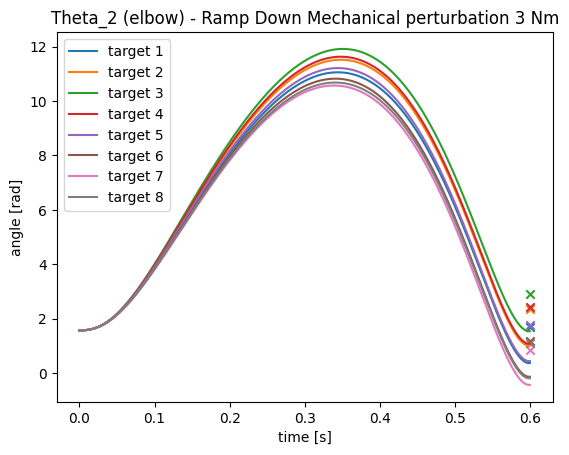

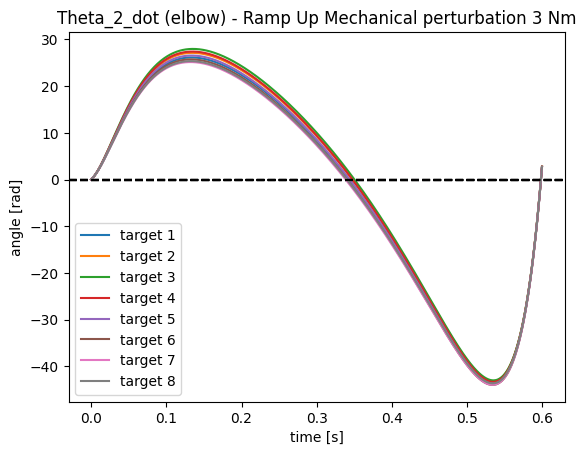

In [12]:
### Simulate a mechanical perturbation ###

theta_1 = np.pi/4
theta_2 = np.pi/2
theta_dot_1 = 0
theta_dot_2 = 0
T_1 = 0 # Nm
T_2 = 0 # Nm
F_ext_1 = 0 # N
F_ext_2 = 3 # N
slope_factor = 3

A_primary = matrix = np.array([
    0, 0, 1, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0, 0,
    0, 0, -0.093353, -3.547423, 7.46826, -7.46826, 7.46826, -7.46826,
    0, 0, -2.991867, 14.658535, -7.46826, 29.6904, -7.46826, 29.6904,
    0, 0, 0, 0, -16.6667, 0, 0, 0,
    0, 0, 0, 0, 0, -16.6667, 0, 0,
    0, 0, 0, 0, 0, 0, 0, slope_factor,
    0, 0, 0, 0, 0, 0, 0, slope_factor
]).reshape(8, 8)

B_primary = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1/tau, 0, 0, 1/tau, 0, 0, 0, 0]).reshape(8, 2)

# A = [A*dt + eye(6) , 0 ; 0 , eye(6)]
A = np.concatenate((A_primary * dt + np.eye(8), np.zeros((8, 8))), axis=1)
A = np.concatenate((A, np.concatenate((np.zeros((8, 8)), np.eye(8)), axis=1)), axis=0)
# add a whole line of zeros to A
print("A shape : ", A.shape)

B = np.concatenate((B_primary * dt, np.zeros((8,2))), axis=0)

# print("B shape : ", B.shape)

weights = np.array([10**6,10**6,10**5,10**5,1,1,0,0])
Q = cost_matrix(weights, 16)
# print(Q)
Qk = np.zeros((16,16))
R = 0.0001 
N = 1000
time = 0.6 # seconds
(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 16)

## for every target with F = 5 Nm
# angles
for i in range(1,9) :
    x = np.zeros((N,16,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, 0, F_ext_2, angles[0,i], angles[1,i], 0, 0, 0, 0, 0, 0]).reshape((16,1))
    x = forward_optimal_control(N, A, B, R, L, x, 16)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,1,0], label = 'target '+str(i))
    
# Plot little "x" dots at the end of the plot with the same color as the line
for i in range(1, 9):
    plt.scatter(time, angles[1, i], marker='x', color=plt.gca().lines[i - 1].get_color())

plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.title('Theta_2 (elbow) - Ramp Down Mechanical perturbation ' + str(F_ext_2) + ' Nm')
plt.legend()
plt.show()

# velocities
for i in range(1,9) :
    x = np.zeros((N,16,1))
    x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, 0, F_ext_2, angles[0,i], angles[1,i], 0, 0, 0, 0, 0, 0]).reshape((16,1))
    x = forward_optimal_control(N, A, B, R, L, x, 16)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,3,0], label = 'target '+str(i))
    # plot an axvline for the 0 value of velocity
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_2_dot (elbow) - Ramp Up Mechanical perturbation ' + str(F_ext_2) + ' Nm')
    plt.legend()
plt.show()


In [13]:
def feedback_delay(A, B, shape, h, N, x_hat, x):
    means = np.zeros(shape)
    cov_ksi = np.zeros((shape,shape))
    for i in range(0,shape) :
        cov_ksi[i,i] = np.abs(np.random.normal(0, 0.001))

    cov_w = np.zeros((shape,shape))
    for i in range(0,shape) :
        cov_w[i,i] = np.abs(np.random.normal(0, 0.001))
        
    H = np.zeros((shape,shape))
    # last 12x12 of H must be identity
    size = int(shape / (h + 1))
    H[-size:,-size:] = np.eye(size)
    sigma = np.zeros((N,shape,shape))
    sigma[0,:,:] = cov_w
    y = np.zeros((N,shape,1))
    K = np.zeros((N,shape,shape))
    u = np.ones((B.shape[1],1))
    for k in range(0,N-1) :
        w = np.random.multivariate_normal(means, cov_w).reshape((shape,1))
        K[k,:,:] = A @ sigma[k,:,:] @ H.T @ np.linalg.inv(H @ sigma[k,:,:] @ H.T + cov_w)
        sigma[k+1,:,:] = cov_ksi + (A - K[k,:,:] @ H) @ sigma[k,:,:] @ A.T
        y[k,:,:] = H @ x[k,:,:] + w
        if k > 0:
            x_hat[k+1,:,:] = A @ x_hat[k,:,:] + B @ u + K[k,:,:] @ (y[k,:,:] - H @ x_hat[k,:,:])
        else:
            x_hat[k+1,:,:] = A @ x_hat[k,:,:] + B @ u + K[k,:,:] @ (y[k,:,:] - H @ x[k,:,:])
    
    return x_hat

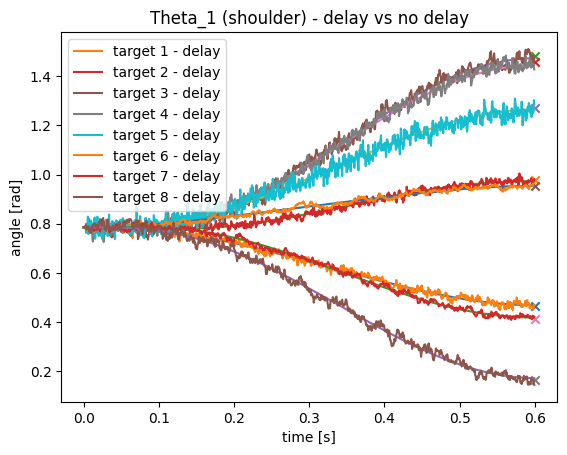

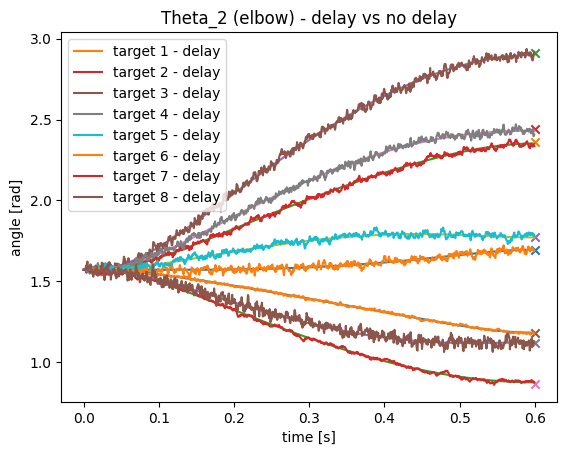

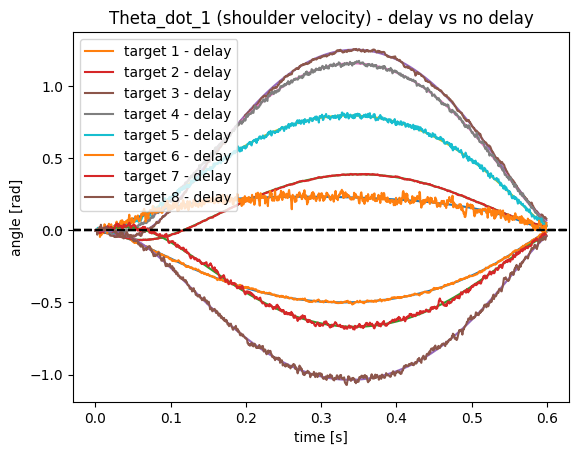

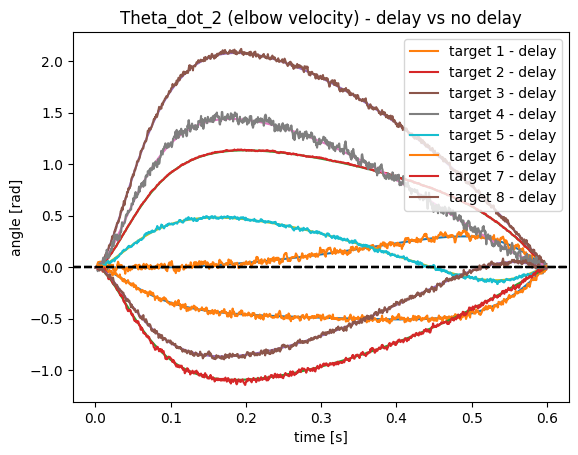

Selected Values is x_1 when N = 4 -  [[ 7.85398673e-01]
 [ 1.57079357e+00]
 [ 3.78444006e-07]
 [-3.30034085e-07]
 [-1.10618342e-02]
 [-1.15329855e-02]
 [ 1.61998907e-01]
 [ 1.11924284e+00]
 [-5.57333710e-07]
 [-1.48945449e-06]
 [-3.57808730e-07]
 [-1.32768149e-07]]
Selected Values is x_1 when N = 5 -  []


In [14]:
### Add delay in the model ###

theta_1 = np.pi/4
theta_2 = np.pi/2
theta_dot_1 = 0
theta_dot_2 = 0
T_1 = 0 # Nm
T_2 = 0 # Nm

A_primary = matrix = np.array([
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 0, 0,
    0, 0, -0.093353, -3.547423, 7.46826, -7.46826,
    0, 0, -2.991867, 14.658535, -7.46826, 29.6904,
    0, 0, 0, 0, -16.6667, 0,
    0, 0, 0, 0, 0, -16.6667
]).reshape(6, 6)

B_primary = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1/tau, 0, 0, 1/tau]).reshape(6, 2)
h = 3
# A = [A*dt + eye(6) , 0 ; 0 , eye(6)]
A = np.concatenate((A_primary * dt + np.eye(6), np.zeros((6, 6))), axis=1)
A = np.concatenate((A, np.concatenate((np.zeros((6, 6)), np.eye(6)), axis=1)), axis=0)
B = np.concatenate((B_primary * dt, np.zeros((6,2))), axis=0)
A_delay_mtx = np.zeros((12*h + 12, 12*h + 12))
A_delay_mtx[0:12, 0:12] = A
B_delay_mtx = np.zeros((12*h + 12, 2))
B_delay_mtx[0:12, 0:2] = B
for i in range(h):
    A_delay_mtx[12 * (i + 1): 12*(i + 2), 12 * i: 12 * (i + 1)] = np.eye(12)

weights = np.array([10**6,10**6,10**5,10**5,1,1])
Q = cost_matrix(weights, 12)
Q = np.kron(np.eye(h + 1), Q)
# print(Q)
Qk = np.zeros((12,12))
Qk = np.kron(np.eye(h + 1), Qk)

R = 0.0001 
N = 1000
u = np.ones((2, 1))
(L, S) = backwards_optimal_control(N, A_delay_mtx, B_delay_mtx, Q, Qk, R, 12 * (h + 1))

w = np.random.normal(0, 0.000001, (12 * (h + 1),1))
time = 0.6 # seconds

x = np.zeros((N, 12 * (h+1), 1))
x_hat = np.zeros((N, 12 * (h+1), 1))
for i in range(1,9):
    x = np.zeros((N, 12 * (h+1), 1))
    x_hat = np.zeros((N, 12 * (h+1), 1))
    x[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A_delay_mtx, B_delay_mtx, R, L, x, 12 * (h + 1))
    x_hat[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x_hat = feedback_delay(A_delay_mtx, B_delay_mtx, 12 * (h + 1), h, N, x_hat, x)
    # plot delay vs no delay
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,0,0])
    plt.plot(x_axis, x_hat[:,0,0], label = 'target '+str(i)+' - delay')
    plt.scatter(time, angles[0, i], marker='x', color=plt.gca().lines[i - 1].get_color())
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_1 (shoulder) - delay vs no delay')
    plt.legend()
plt.show()
for i in range(1,9) :
    x = np.zeros((N, 12 * (h+1), 1))
    x_hat = np.zeros((N, 12 * (h+1), 1))
    x[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A_delay_mtx, B_delay_mtx, R, L, x, 12 * (h + 1))
    x_hat[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x_hat = feedback_delay(A_delay_mtx, B_delay_mtx, 12 * (h + 1), h, N, x_hat, x)
    # plot delay vs no delay
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,1,0])
    plt.plot(x_axis, x_hat[:,1,0], label = 'target '+str(i)+' - delay')
    plt.scatter(time, angles[1, i], marker='x', color=plt.gca().lines[i - 1].get_color())
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_2 (elbow) - delay vs no delay')
    plt.legend()
plt.show()

# velocities
for i in range(1,9) :
    x = np.zeros((N, 12 * (h+1), 1))
    x_hat = np.zeros((N, 12 * (h+1), 1))
    x[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A_delay_mtx, B_delay_mtx, R, L, x, 12 * (h + 1))
    x_hat[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x_hat = feedback_delay(A_delay_mtx, B_delay_mtx, 12 * (h + 1), h, N, x_hat, x)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,2,0])
    plt.plot(x_axis, x_hat[:,2,0], label = 'target '+str(i)+' - delay')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_dot_1 (shoulder velocity) - delay vs no delay')
    plt.legend()
plt.show()
for i in range(1,9) :
    x = np.zeros((N, 12 * (h+1), 1))
    x_hat = np.zeros((N, 12 * (h+1), 1))
    x[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x = forward_optimal_control(N, A_delay_mtx, B_delay_mtx, R, L, x, 12 * (h + 1))
    x_hat[0,0:12,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, angles[0,i], angles[1,i], 0, 0, 0, 0]).reshape((12,1))
    x_hat = feedback_delay(A_delay_mtx, B_delay_mtx, 12 * (h + 1), h, N, x_hat, x)
    x_axis = np.arange(0, time, time/N)
    plt.plot(x_axis, x[:,3,0])
    plt.plot(x_axis, x_hat[:,3,0], label = 'target '+str(i)+' - delay')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel("time [s]")
    plt.ylabel("angle [rad]")
    plt.title('Theta_dot_2 (elbow velocity) - delay vs no delay')
    plt.legend()
plt.show()

print("Selected Values is x_1 when N = 4 - ", x[4, 36:48])
print("Selected Values is x_1 when N = 5 - ", x[5, 48:60])